In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mxnet as mx
from mxnet import gluon

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs




In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'context_length': 11,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'method_names': ["ets", "arima"],
    'epochs': 10,
    'save_model': False,
    'evaluate_model': True
}


In [5]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def get_gluon_ds():

    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(tf.values[:, :-metadata['prediction_length']],
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(tf.values,
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])
          
    return train_ds, test_ds

In [6]:
import inspect
from pathlib import Path

from gluonts.model.r_forecast import RForecastPredictor
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def get_cls_attributes(cls):
    attributes = inspect.getmembers(cls, lambda x: not(inspect.isroutine(x)))
    attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
    return dict(attributes)


def get_hyperparams(estimator, predictor_id):
    predictor = type(estimator).__name__
    estimator_attr = get_cls_attributes(estimator)
    if predictor == "RForecastPredictor":
        estimator_attr['predictor'] = predictor
        estimator_attr['predictor_id'] = predictor_id
        return dict(estimator_attr)
    trainer_attr = get_cls_attributes(estimator_attr['trainer'])
    attributes = {**estimator_attr, **trainer_attr}
    attributes.pop('trainer', None)
    attributes['predictor'] = predictor
    attributes['predictor_id'] = predictor_id
    return dict(attributes)


def to_model_database(attributes):
    fpath = os.path.join(data_dir, 'sensitivity-metrics.csv')
    if not os.path.exists(fpath):
        pd.DataFrame([attributes]).to_csv(fpath, header=True, index=False)
        return print(f"Created metrics database: {fpath}")
    params = pd.read_csv(fpath)
    to_add_params = pd.DataFrame([attributes])
    updated_params = pd.concat([params, to_add_params], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)
    return print(f"Updated metrics database: {fpath}")
      
        
def eval_loop(method):
    estimator = RForecastPredictor(
        freq=metadata['freq'],  
        prediction_length=metadata['prediction_length'],
        method_name = method
        )
    
    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)

    if metadata['evaluate_model'] is True:
        forecast_it, ts_it = make_evaluation_predictions(
            test_ds, predictor=estimator, num_samples=100
        )
        agg_metrics, item_metrics = Evaluator()(
            ts_it, forecast_it, num_series=len(test_ds)
        )
        attributes = {**attributes, **agg_metrics}

    to_model_database(attributes) 
  

In [7]:
for prediction_length in np.arange(1, 12):
    for method in metadata['method_names']:
        metadata['prediction_length'] = prediction_length
        train_ds, test_ds = get_gluon_ds()
#         test_ds = ListDataset(test_ds.list_data[:200], freq=metadata['freq'])
        eval_loop(method)

/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 100%|██████████| 37111/37111 [12:12<00:00, 50.68it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:35:27<00:00,  6.48it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:33<00:00, 53.55it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:08:16<00:00,  9.06it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:33<00:00, 53.55it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:07:19<00:00,  9.19it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:27<00:00, 53.97it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:06:35<00:00,  9.29it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:31<00:00, 53.67it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:05:23<00:00,  9.46it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:30<00:00, 53.78it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:05:12<00:00,  9.49it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:30<00:00, 53.71it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:04:00<00:00,  9.66it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [11:37<00:00, 53.24it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:04:41<00:00,  9.56it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [12:57<00:00, 47.76it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:07:08<00:00,  9.21it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [12:32<00:00, 49.34it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:06:07<00:00,  9.35it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [12:58<00:00, 47.64it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


Running evaluation: 100%|██████████| 37111/37111 [1:05:15<00:00,  9.48it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


In [15]:
tmp = pd.read_csv(fpath)
# tmp['predictor'].unique()

tmp2 = tmp.loc[tmp['predictor']=='RForecastPredictor']

In [20]:
ets.columns

Index(['add_trend', 'cardinality', 'cell_type', 'dropout_rate', 'dtype',
       'embedding_dimension', 'freq', 'innovation_bounds', 'issm', 'lead_time',
       'noise_std_bounds', 'num_cells', 'num_layers', 'num_parallel_samples',
       'past_length', 'prediction_length', 'prior_cov_bounds', 'scaling',
       'time_features', 'use_feat_dynamic_real', 'use_feat_static_cat',
       'batch_size', 'clip_gradient', 'ctx', 'epochs', 'halt', 'hybridize',
       'init', 'learning_rate', 'learning_rate_decay_factor',
       'minimum_learning_rate', 'num_batches_per_epoch', 'patience',
       'weight_decay', 'predictor', 'predictor_id', 'MSE', 'abs_error',
       'abs_target_sum', 'abs_target_mean', 'seasonal_error', 'MASE', 'MAPE',
       'sMAPE', 'OWA', 'MSIS', 'QuantileLoss[0.1]', 'Coverage[0.1]',
       'QuantileLoss[0.2]', 'Coverage[0.2]', 'QuantileLoss[0.3]',
       'Coverage[0.3]', 'QuantileLoss[0.4]', 'Coverage[0.4]',
       'QuantileLoss[0.5]', 'Coverage[0.5]', 'QuantileLoss[0.6]',
   

In [28]:
tmp['predictor'].unique()

array(['DeepStateEstimator', 'RForecastPredictor',
       'SimpleFeedForwardEstimator', 'linregress'], dtype=object)

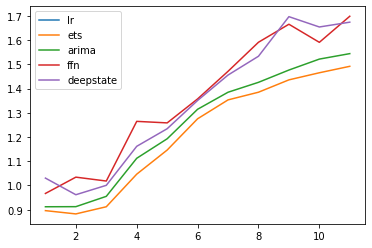

In [43]:

lr = tmp.loc[tmp['predictor']=='linregress']
ets = tmp.loc[tmp['method_name']=='ets']
arima = tmp.loc[tmp['method_name']=='arima']
ffn = tmp.loc[tmp['predictor']=='SimpleFeedForwardEstimator']
deepstate = tmp.loc[tmp['predictor']=='DeepStateEstimator']


def plot_metric(ax, method):
    ax.plot(lr['prediction_length'], lr[method], label='lr')
    ax.plot(ets['prediction_length'], ets[method], label='ets')
    ax.plot(arima['prediction_length'], arima[method], label='arima')
    ax.plot(ffn['prediction_length'], ffn[method], label='ffn')
    ax.plot(deepstate['prediction_length'], deepstate[method], label='deepstate')
    ax.legend()
    return ax

fig, ax = plt.subplots()
plot_metric(ax, method='MASE')

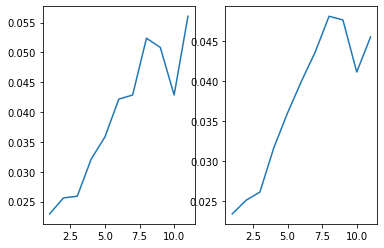

In [14]:
tmp = pd.read_csv(fpath)
selection = tmp.loc[tmp['predictor']=='RForecastPredictor']

fig, axes = plt.subplots(nrows=1, ncols=2)
for df, ax in zip(tmp.groupby('method_name'), axes.flatten()):
    ax.plot(df[1]['prediction_length'], df[1]['MAPE'])
    

In [ ]:
def evaluate_r_methods(method_names: list, dataset) -> pd.DataFrame:
    results = []
    for method in method_names:
        predictor = RForecastPredictor(
            freq=metadata['freq'],  
            prediction_length=metadata['prediction_length'],
            method_name = method
            )
      
        forecast_it, ts_it = make_evaluation_predictions(
            dataset, predictor=predictor, num_samples=100
        )        

        
        evaluator = Evaluator()

        agg_metrics, item_metrics = evaluator(ts_it, forecast_it)
        
        item_metrics["prediction_length"] = metadata["prediction_length"]
        item_metrics["context_length"] = metadata["context_length"]
        item_metrics["predictor"] = method
        item_metrics["predictor_id"] = get_predictor_id()
        item_metrics["item_id"] = [i["item_id"] for i in iter(dataset)]
        
        results.append(item_metrics)
    return pd.concat(results)


def sample_df(forecast):
    samples = forecast.samples
    ns, h = samples.shape
    dates = pd.date_range(forecast.start_date, freq=forecast.freq, periods=h)
    return pd.DataFrame(samples.T, index=dates)

def forecast_r_methods(method_names: list, dataset) -> dict():
    fcst_dict = {}
    for method in method_names:
        predictor = RForecastPredictor(
            freq=metadata["freq"],
            prediction_length=metadata["prediction_length"],
            method_name=method
        )
        
        fcst_dict[method] = predictor.predict(dataset)        
    return fcst_dict

def forecasts_df(dataset, forecast_it):
    ds_it = iter(dataset)
    parts = [sample_df(transect_id).assign(transect_id=i["item_id"])
             for i, transect_id in zip(ds_it, forecast_it)]
    return pd.concat(parts)

In [8]:
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def evaluate_r_methods(dataset, prediction_length):
    context_length = metadata['num_steps'] - prediction_length
    results = []
    for method in metadata['method_names']:
        predictor = RForecastPredictor(
            freq=metadata['freq'],  
            prediction_length=prediction_length,
            method_name = method
            )
      
        forecast_it, ts_it = make_evaluation_predictions(
            dataset, predictor=predictor, num_samples=100
        )        

        
        evaluator = Evaluator()

        agg_metrics, item_metrics = evaluator(ts_it, forecast_it)
        
        item_metrics["prediction_length"] = prediction_length
        item_metrics["context_length"] = context_length
        item_metrics["predictor"] = method
        item_metrics["predictor_id"] = get_predictor_id()
        item_metrics["item_id"] = [i["item_id"] for i in iter(dataset)]
        
        results.append(item_metrics)
    return pd.concat(results)

In [9]:
results = []
for prediction_length in np.arange(5, 28, 4):
    metrics = evaluate_r_methods(test_ds, prediction_length)
    results.append(metrics)
    pd.concat(results).to_csv("/media/storage/data/shorelines/ets-arima-robustness.csv", index=False, header=True)

/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 37111it [11:34, 53.42it/s]
Running evaluation: 37111it [1:05:23,  9.46it/s]
Running evaluation: 37111it [11:26, 54.06it/s]
Running evaluation: 37111it [1:02:21,  9.92it/s]
Running evaluation: 37111it [11:26, 54.07it/s]
Running evaluation: 37111it [58:04, 10.65it/s]
Running evaluation: 37111it [11:36, 53.31it/s]
Running evaluation: 37111it [54:43, 11.30it/s]
Running evaluation: 37111it [11:39, 53.02it/s]
Running evaluation: 37111it [52:38, 11.75it/s]
Running evaluation: 37111it [11:40, 52.96it/s]
Running evaluation: 37111it [38:01, 16.27it/s]


In [ ]:
metrics = evaluate_r_methods(["ets", "arima"], test_ds)
# forecasts = forecast_r_methods(["ets", "arima"], test_ds)
# ts_it = iter(test_ds)
# ets_fcst_it = iter(forecasts["ets"])
# arima_fcst_it = iter(forecasts["arima"])

/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 37112it [14:57, 41.35it/s]
Running evaluation: 27546it [59:42,  5.41it/s]

In [143]:
ets_fcst_entry = next(ets_fcst_it)
arima_fcst_entry = next(arima_fcst_it)
ts_entry = next(ts_it)

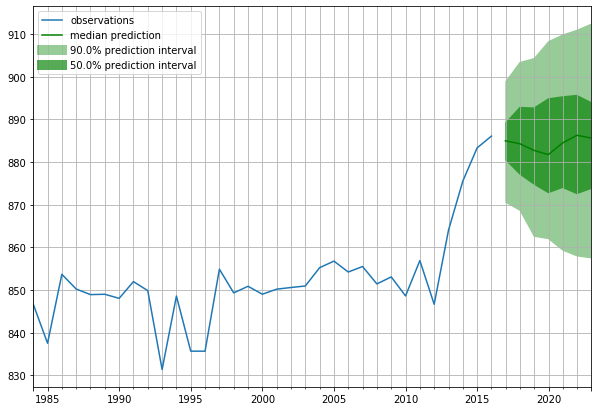

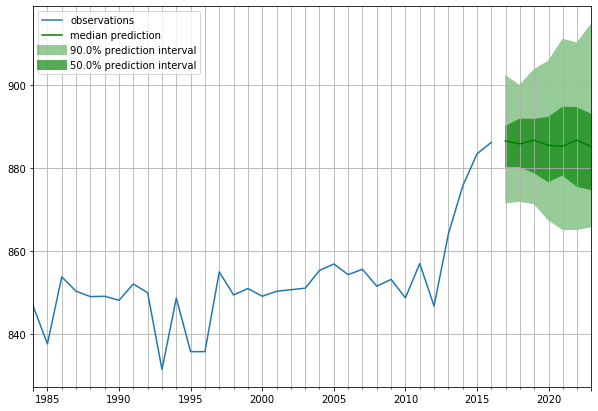

In [144]:
def plot_prob_forecasts(ts_entry, fcst_entry):
    ts_idx = pd.date_range(start=ts_entry["start"],periods=len(ts_entry["target"]),freq="AS")
    ts = pd.Series(ts_entry["target"], index=ts_idx)
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts.plot(ax=ax)  # plot the time series
    
    fcst_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

    
plot_prob_forecasts(ts_entry, ets_fcst_entry)
plot_prob_forecasts(ts_entry, arima_fcst_entry)

### Predict specific transects

In [75]:
def rforecast_transect(transects, dataset, method='arima', freq=None, 
                       prediction_length=None, **kwargs):
    
    if prediction_length is None:
        prediction_length = metadata['prediction_length']
        
    if freq is None:
        freq = metadata['freq']

    dataset_it = iter(dataset)
    
    dataset = ListDataset(
        [
            i for i in dataset_it if i['item_id'] in transects
        ], 
        freq=metadata['freq']
    )
    
    predictor = RForecastPredictor(
        freq=freq,
        prediction_length=prediction_length,
        method_name=method
    )
    
    return iter(dataset), predictor.predict(dataset)
     
    
duck = [f'BOX_160_055_3{i}' for i in np.arange(42, 50, 1)]    

arima_ts_it, arima_forecast_it = rforecast_transect(
    transects=duck,
    dataset=test_ds,
    method='arima',
    prediction_length=15
)

ets_ts_it, ets_forecast_it = rforecast_transect(
    transects=duck,
    dataset=test_ds,
    method='ets',
    prediction_length=15
)        
    
    


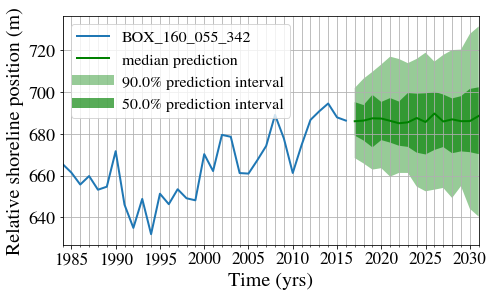

In [76]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl

plt.style.use(os.path.join(configuration_dir, 'PaperSingleFig.mplstyle'))

def plot_prob_forecast(ax, ts_entry, fcst_entry):
    
    prediction_intervals = (50.0, 90.0)
    legend = [f"{ts_entry['item_id']}", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    
    ts_idx = pd.date_range(
        start=ts_entry["start"],
        periods=len(ts_entry["target"]),
        freq="AS"
    )
    
    
    ts = pd.Series(ts_entry["target"], index=ts_idx)
    ts.plot(ax=ax)  # plot the time series
    
    fcst_entry.plot(
        prediction_intervals=prediction_intervals,
        color='g'
    ) 
    
    ax.set_ylabel('Relative shoreline position (m)')
    ax.set_xlabel('Time (yrs)')
    ax.grid(which="both")
    ax.legend(legend, loc="upper left")
    
    return ax




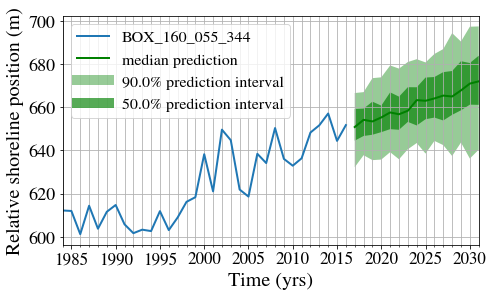

In [78]:
fig, ax = plt.subplots()
plot_prob_forecast(ax, next(arima_ts_it), next(arima_forecast_it))
plt.savefig(os.path.join(report_dir, 'images/arima.pdf'), dpi=300)
plt.show()

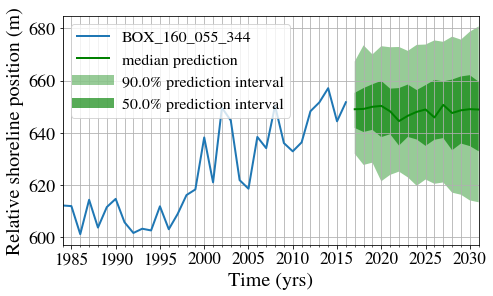

In [81]:
fig, ax = plt.subplots()
plot_prob_forecast(ax, next(ets_ts_it), next(ets_forecast_it))
plt.savefig(os.path.join(report_dir, 'images/ets.pdf'), dpi=300)
plt.show()

### Linear regression

In [8]:
from scipy import stats

from shorelineforecasting.utils.forecasting_metrics import evaluate 
# from utils import get_predictor_id

y = lambda intercept, slope, x: intercept + slope * x

def lr(obs, forecast=False):
    x = range(len(obs))
    slope, intercept, _, _, _ = stats.linregress(x, obs)
    if forecast is True:
        x = range(len(obs) + metadata["prediction_length"])
    return [y(intercept, slope, x) for x in x]

def make_evaluation_predictions_lr(dataset, metrics: list):
    dataset = dataset.list_data
    results = []
    for i in dataset:
        fcast = lr(i["target"][:-metadata["prediction_length"]], forecast=True)
        eval_dict = evaluate(actual = i["target"][-metadata["prediction_length"]:], 
                             predicted = fcast[-metadata["prediction_length"]:], 
                             metrics = metrics)
        eval_dict["item_id"] = i["item_id"]
        results.append(eval_dict)
    return results

# results = make_evaluation_predictions_lr(test_ds, metrics=["mse", "mase", "mape", "smape", "rmse", "nrmse", "abs_error", "mae"])
# lr_metrics = pd.DataFrame(results)

In [29]:
lr_metrics['predictor'] = 'linregress'
lr_metrics['predictor_id'] = 0
lr_metrics.columns = ['MSE', 'MASE', 'MAPE', 'sMAPE', 'RMSE', 'nRMSE', 'abs_error', 'MAE', 'item_id', 'predictor', 'predictor_id']
lr_metrics

In [9]:
fpath = os.path.join(data_dir, 'sensitivity-metrics.csv')

for prediction_length in np.arange(1, 12):
    metadata['prediction_length'] = prediction_length
    results = make_evaluation_predictions_lr(test_ds, metrics=["mse", "mase", "mape", "smape", "rmse", "nrmse", "abs_error", "mae"])
    lr_metrics = pd.DataFrame(results)
    lr_metrics = pd.DataFrame(lr_metrics.mean()).T
    lr_metrics.columns = ['MSE', 'MASE', 'MAPE', 'sMAPE', 'RMSE', 'nRMSE', 'abs_error', 'MAE']
    lr_metrics['predictor_id'] = get_predictor_id
    lr_metrics['predictor'] = 'linregress'
    lr_metrics['prediction_length'] = prediction_length
    params = pd.read_csv(fpath)
    updated_params = pd.concat([params, lr_metrics], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)


/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/media/storage/dev/shorelineforecasting/shorelineforecasting/utils/forecasting_metrics.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return rmse(actual, predicted) / (actual.max() - actual.min())
/media/storage/dev/shorelineforecasting/shorelineforecasting/utils/forecasting_metrics.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


In [25]:
ets_arima_metrics = pd.read_pickle("/media/storage/data/shorelines/ets-arima-metrics.pkl")
lr_metrics = pd.read_pickle("/media/storage/data/shorelines/lr-metrics.pkl")
ets_metrics = ets_arima_metrics.loc[ets_arima_metrics["predictor"]=="ets"]
arima_metrics = ets_arima_metrics.loc[ets_arima_metrics["predictor"]=="arima"]

In [26]:
lr_metrics["MAPE"] = lr_metrics["mape"]
for i in [lr_metrics, ets_metrics, arima_metrics]:
    print(i["MAPE"].mean())

0.05071888328463737
0.04355436456437403
0.04220988850904515


In [40]:
lr_metrics.select_dtypes(include=[np.float])

,mse,mase,mape,smape,rmse,nrmse,MAPE
0,2184.934204,1.303097,0.059512,0.061263,46.743280,0.472199,0.059512
1,1152.427279,4.259721,0.040382,0.041303,33.947419,1.024420,0.040382
2,1540.350971,0.742026,0.032867,0.031695,39.247305,0.366539,0.032867
3,49.398626,1.934156,0.008152,0.008115,7.028416,1.251164,0.008152
4,1298.588458,3.052631,0.113803,0.107121,36.035933,1.214348,0.113803
...,...,...,...,...,...,...,...
37107,652.911778,0.862765,0.036507,0.036816,25.552138,0.329099,0.036507
37108,406.047901,0.767782,0.034232,0.035460,20.150630,0.422489,0.034232
37109,274.882671,0.988831,0.021447,0.021444,16.579586,0.365029,0.021447
37110,2077.990451,0.844995,0.076780,0.075449,45.584981,0.384775,0.076780


In [50]:
for metrics, method in zip([lr_metrics, ets_metrics, arima_metrics], ["lr", "ets", "arima"]):
    for i in list(metrics.select_dtypes(include=[np.float])):
        print(f"{method}: {i}: {metrics[i].mean()}")
    print("---"*10)



lr: mse: 2510.2638056759442
lr: mase: inf
lr: mape: 0.05071888328463737
lr: smape: 0.032803455336974215
lr: rmse: 22.44791489254638
lr: nrmse: inf
lr: MAPE: 0.05071888328463737
------------------------------
ets: MSE: 2020.3934760547181
ets: abs_error: 117.39256498760469
ets: abs_target_sum: 5148.112319531485
ets: abs_target_mean: 735.4446170759264
ets: seasonal_error: 13.435122173964707
ets: MASE: 1.3533420920892136
ets: MAPE: 0.04355436456437403
ets: sMAPE: 0.02755854137872076
ets: OWA: nan
ets: MSIS: 16.74299618909899
ets: QuantileLoss[0.1]: 58.11150861157645
ets: Coverage[0.1]: 0.1339420441597635
ets: QuantileLoss[0.2]: 86.49399645630605
ets: Coverage[0.2]: 0.2253641486773627
ets: QuantileLoss[0.3]: 104.1369874396795
ets: Coverage[0.3]: 0.3153427462815262
ets: QuantileLoss[0.4]: 113.592096165004
ets: Coverage[0.4]: 0.40562159332368425
ets: QuantileLoss[0.5]: 117.39256498760469
ets: Coverage[0.5]: 0.5050849936870632
ets: QuantileLoss[0.6]: 118.24652055553011
ets: Coverage[0.6]: 0.59